In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt

part A

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv("ratings.csv")
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
ratings.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [7]:
movies['List Index'] = movies.index

part B

In [8]:
df = pd.merge(movies,ratings,on = "movieId")

part C

In [9]:
del df["title"]
del df["genres"]
del df["timestamp"]

In [10]:
print(df.head())

   movieId  List Index  userId  rating
0        1           0       1     4.0
1        1           0       5     4.0
2        1           0       7     4.5
3        1           0      15     2.5
4        1           0      17     4.5


part D

In [11]:
Grouped_df = df.groupby('userId')
Grouped_df.head()

,movieId,List Index,userId,rating
0,1,0,1,4.0
1,1,0,5,4.0
2,1,0,7,4.5
3,1,0,15,2.5
4,1,0,17,4.5
...,...,...,...,...
68658,5816,4076,556,4.5
69478,5989,4159,550,4.0
72615,6874,4615,2,4.0
75076,7444,4939,506,3.0


part E

In [50]:
Users_num = 610
train_X = []
for userId, curUser in Grouped_df:

    temp = [0]*len(movies)
    for num, movie in curUser.iterrows():
        temp[int(movie['List Index'])] = movie['rating']/5.0
    train_X.append(temp)
print(train_X)
train_X = torch.FloatTensor(train_X)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



part F

In [51]:
class RBM():
    def __init__(self, nv, nh,alpha):
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh)
        self.b = torch.randn(1, nv)
        self.alpha = alpha
    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    def train(self, v0, vk, ph0, phk):
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        self.b += self.alpha*torch.sum((v0 - vk), 0)
        self.a += self.alpha*torch.sum((ph0 - phk), 0)

nv = len(train_X[0])
nh = 20
batch_size = 100
rbm = RBM(nv, nh,0.05)

part G

epoch: 1 loss: tensor(0.1472)
epoch: 2 loss: tensor(0.0332)
epoch: 3 loss: tensor(0.0284)
epoch: 4 loss: tensor(0.0263)
epoch: 5 loss: tensor(0.0250)
epoch: 6 loss: tensor(0.0243)
epoch: 7 loss: tensor(0.0238)
epoch: 8 loss: tensor(0.0233)
epoch: 9 loss: tensor(0.0230)
epoch: 10 loss: tensor(0.0228)
epoch: 11 loss: tensor(0.0226)
epoch: 12 loss: tensor(0.0224)
epoch: 13 loss: tensor(0.0224)
epoch: 14 loss: tensor(0.0222)
epoch: 15 loss: tensor(0.0221)
epoch: 16 loss: tensor(0.0220)
epoch: 17 loss: tensor(0.0220)
epoch: 18 loss: tensor(0.0219)
epoch: 19 loss: tensor(0.0219)
epoch: 20 loss: tensor(0.0218)


Text(0.5, 0, 'eploch')

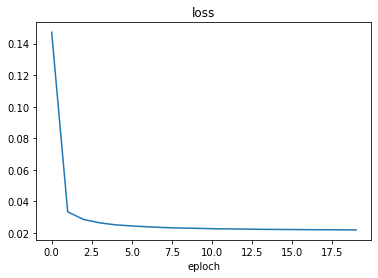

In [52]:
nb_epoch = 20
nb_users = len(train_X)
loss = []
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, nb_users - batch_size, batch_size):
        vk = train_X[id_user:id_user+batch_size]
        v0 = train_X[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range(10):
            _,hk= rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))
    loss.append(train_loss.float()/s)
plt.plot(loss)
plt.title('loss')
plt.xlabel('eploch')

part H

In [57]:
test_User = train_X[450: 451]
_, h = rbm.sample_h(test_User)
_, test_User = rbm.sample_v(h)
test_User = test_User.detach().numpy()
test_User = test_User.argsort()[0][-15:-1]
for movie in test_User:
  print(movies[movies['List Index'] == movie])


      movieId                   title                     genres  List Index
1476     2001  Lethal Weapon 2 (1989)  Action|Comedy|Crime|Drama        1476
      movieId           title                genres  List Index
3016     4034  Traffic (2000)  Crime|Drama|Thriller        3016
     movieId                                      title            genres  \
990     1291  Indiana Jones and the Last Crusade (1989)  Action|Adventure   

     List Index  
990         990  
      movieId         title                    genres  List Index
2302     3052  Dogma (1999)  Adventure|Comedy|Fantasy        2302
      movieId                title           genres  List Index
7965    96417  Premium Rush (2012)  Action|Thriller        7965
      movieId                                 title  genres  List Index
9151   147384  Doctor Who: The Runaway Bride (2007)  Sci-Fi        9151
      movieId                     title                  genres  List Index
4764     7090  Hero (Ying xiong) (2002)  Action